In [ ]:
# Copyright (c) 2025 Chase Holdener
# Licensed under the MIT License. See LICENSE file for details.

## Import Packages

In [1]:
### Import External Required Packages
print("importing anndata...")
import anndata as ad
print("importing numpy...")
import numpy as np
print("importing pandas...")
import pandas as pd
print("importing scanpy...")
import scanpy as sc
print("importing matplotlib.pylot...")
import matplotlib.pyplot as plt
import sys

### Import Smoothie Functions
sys.path.append('/path/to/Smoothie/src/') # Make this the path to the Smoothie src directory!
from gaussian_smoothing import *
from spatial_correlation import *
from network_analysis import *
from plotting import *

importing anndata...
importing numpy...
importing pandas...
importing scanpy...
importing matplotlib.pylot...


## Load AnnData

In [2]:
## Load in anndata structure (raw count matrix)
adata = ad.read_h5ad("./rodriques_slideseq.h5ad")

# This Slide-seq Puck_180819_12 dataset .h5ad file was obtained from the Hotspot github page
# https://hotspot.readthedocs.io/en/latest/Spatial_Tutorial.html. This data is also available from the 
# original Slide-seq paper here https://singlecell.broadinstitute.org/single_cell/study/SCP354/slide-seq-study#study-summary

## Quality Control + Preprocessing

#### QC filtering depends on the spatial transcriptomics platform and its spatial resolution

#### Slide-seq (10 micron resolution spots): 
- SPOT_UMI_THRESHOLD [10-200]
- GENE_UMI_THRESHOLD [100-500]

#### Binned Stereo-seq (20-50 micron resolution spots):
- SPOT_UMI_THRESHOLD [50-500]
- GENE_UMI_THRESHOLD [100-500]

#### Unbinned Stereo-seq (0.5 micron resolution spots):
- SPOT_UMI_THRESHOLD [1-2] **
- GENE_UMI_THRESHOLD [100-500]

In [3]:
# Keep SPOTS that have at least SPOT_UMI_THRESHOLD counts across all genes
SPOT_UMI_THRESHOLD = 5
adata.obs['total_raw_spotcounts'] = np.sum(adata.X, axis = 1)
adata = adata[adata.obs['total_raw_spotcounts'] >= SPOT_UMI_THRESHOLD, :]

GENE_SPOT_THRESHOLD = 50
gene_nz = np.array((adata.X > 0).sum(axis=0)).ravel()
adata = adata[:, gene_nz >= GENE_SPOT_THRESHOLD]
adata.var['total_raw_counts'] = np.array(np.sum(adata.X, axis=0))[0]

# Other QC filters may be included

/tmp/ipykernel_1291767/564965852.py:9: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['total_raw_counts'] = np.array(np.sum(adata.X, axis=0))[0]


## Normalization

#### Choose Normalization 
1. CPT + log1p normalization (DEFAULT)
2. log1p normalization only (For unbinned sub-micron resolution data)

In [4]:
## CPT + Log1p normalization
TARGET_SUM = 1e3
sc.pp.normalize_total(adata, target_sum=TARGET_SUM)
sc.pp.log1p(adata)
adata.var['norm_total_counts'] = np.array(np.sum(adata.X, axis=0))[0]

## Run Gaussian smoothing

#### Notable Parameters:
#### grid_based_or_not : bool
- True = grid-based smoothing, smooth only at imposed hexagonal grid points, good for subcellular resolution data (0.5-2 micron).
- False = in-place smoothing, smooth at every spatial location in the dataset, good for "cell-sized" resolution data (10-50 micron).

#### gaussian_sd : float
- Standard deviation for the Gaussian kernel. Carefully choose this variable based on S.T. data platform.
- For Slide-seq, a value of 46.37 - 61.82 (30um - 40um) is appropriate.
- For Stereo-seq sub-micron spots, a value of 40 - 60 (20um to 30um) is appropriate.
- Generally across high-resolution S.T. platforms, the range 20-40um is likely ideal.
- Note: Each S.T. data platform has a different conversion factor from their coordinate units to micrometers.

#### min_spots_under_gaussian : int
- Minimum number of data points within radius (3 * gaussian_sd) of center point for smoothing to occur at that location
- (default is 25-100).

#### stride : float, optional
- Stride value for grid-based smoothing (default stride = 1 * gaussian_sd). 
- (0.5 * gaussian_sd is reasonable too for a denser grid).

#### (Check src code for full parameter list).

#### Returns:
#### sm_adata : AnnData
- The smoothed AnnData object.

In [5]:
# In-place smoothing (Slide-seq 10um resolution default parameters)
sm_adata = run_parallelized_smoothing(adata,
                                      grid_based_or_not=False,
                                      gaussian_sd=46.37, # ADJUST AS NEEDED (46.37 corresponds to 30 microns for Slide-seq)
                                      min_spots_under_gaussian=100)

Storage for smoothed count matrix will be 0.91 GB. 

Gaussian smoothing running on chunk 1 of 4... 
Gaussian smoothing running on chunk 2 of 4... 
Gaussian smoothing running on chunk 3 of 4... 
Gaussian smoothing running on chunk 4 of 4... 
Total runtime for in-place Gaussian smoothing: 3.79 seconds.


## Run Smoothing on Shuffled Dataset

Here we generate a spatially shuffled version of the adata to find the 95th, 99th, and 99.9th percentiles of the top Pearson correlation coefficients under the random null hypothesis. These cutoffs are used to select a PCC cutoff for network construction in the dataset.

In [6]:
# Shuffling of all coordinates (For 10-50 micron resolution data)
sh_adata = adata.copy()
np.random.seed(0)
np.random.shuffle(sh_adata.obsm['spatial'])

In [7]:
# Use identical smoothing parameters as you did on the true dataset

# In-place smoothing (Slide-seq 10um resolution default parameters)
sm_sh_adata = run_parallelized_smoothing(sh_adata,
                                         grid_based_or_not=False,
                                         gaussian_sd=46.37, # ADJUST AS NEEDED (46.37 corresponds to 30 microns for Slide-seq)
                                         min_spots_under_gaussian=100)

Storage for smoothed count matrix will be 0.91 GB. 

Gaussian smoothing running on chunk 1 of 4... 
Gaussian smoothing running on chunk 2 of 4... 
Gaussian smoothing running on chunk 3 of 4... 
Gaussian smoothing running on chunk 4 of 4... 
Total runtime for in-place Gaussian smoothing: 3.71 seconds.


## Calculate Pairwise Gene Correlation Matrix

In [8]:
# Pairwise PearsonR across all genes
pearsonR_mat, p_val_mat = compute_correlation_matrix(sm_adata.X)

# Pairwise PearsonR across all shuffled genes
pearsonR_mat_sh, p_val_mat_sh = compute_correlation_matrix(sm_sh_adata.X)

compute_correlation_matrix running...
Total runtime for compute_correlation_matrix: 24.667059421539307 seconds.
compute_correlation_matrix running...
Total runtime for compute_correlation_matrix: 24.73105549812317 seconds.


In [9]:
# Get the indices of the lower triangle of the matrix
lower_tri_indices = np.tril_indices(pearsonR_mat.shape[0], -1)

# True Data distribution
true_lower_tri_values = pearsonR_mat[lower_tri_indices]
print(f'95th PCC percentile for true data: {np.percentile(true_lower_tri_values, 95)}')
print(f'99th PCC percentile for true data: {np.percentile(true_lower_tri_values, 99)}')
print(f'99.9th PCC percentile for true data: {np.percentile(true_lower_tri_values, 99.9)}')

# Shuffled Data distribution
permuted_lower_tri_values = pearsonR_mat_sh[lower_tri_indices]
print(f'95th PCC percentile for shuffled data: {np.percentile(permuted_lower_tri_values, 95)}')
print(f'99th PCC percentile for shuffled data: {np.percentile(permuted_lower_tri_values, 99)}')
print(f'99.9th PCC percentile for shuffled data: {np.percentile(permuted_lower_tri_values, 99.9)}')

95th PCC percentile for true data: 0.1510474532842636
99th PCC percentile for true data: 0.21901672929525307
99.9th PCC percentile for true data: 0.3321389099955637
95th PCC percentile for shuffled data: 0.09455548226833344
99th PCC percentile for shuffled data: 0.13358240276575073
99.9th PCC percentile for shuffled data: 0.21652603939175635


## Make Spatial Gene Correlation Network

#### Notable Parameters:
#### pcc_cutoff : float (in interval (0,1))
- The Pearson correlation coefficient (PCC) hard threshold for network construction.
- Only correlations above this value are retained in the network.
- The pcc_cutoff should be higher than the upper 95th-99.9th percentile of pairwise PCC values generated from the smoothed spatially shuffled count matrix. (pcc_cutoff=0.4 (+/- 0.1) is usually an effective choice.)
* Higher values result in smaller, stronger average correlation networks.
* Lower values result in larger, weaker average correlation networks

#### clustering_power : float (greater than 1)
- A soft thresholding parameter that controls the rescaling of Pearson correlation values. Defaults to 4 if None.
- Prior to soft thresholding, correlation values are linearly rescaled from interval (pcc_cutoff, 1) to (0,1).
* Higher values result in more modular networks.

#### gene_labels_list : list of list/tuple/np.ndarray, optional
- A list containing gene set labels. Each item in the list should have the same length as the number of genes.
- This is useful if you'd like to add gene information to the network for visualization.

#### gene_labels_names : list, optional
- A list of names, with each name corresponding to a gene set in `gene_labels_list`.

#### (Check src code for full parameter list).

#### Returns:
#### edge_list : list
- List of edges in the format [gene1, gene2, PCC, Rescaled_PCC].
- May be imported as network into Cytoscape for visualization!

#### node_label_df : pd.DataFrame
- DataFrame with gene names, community labels, and various network metrics.
- May be imported as node table into Cytoscape for visualization!

In [10]:
edge_list, node_label_df = make_spatial_network(pearsonR_mat,
                                                gene_names=sm_adata.var_names,
                                                pcc_cutoff=0.35,
                                                clustering_power=4,
                                                gene_labels_list=None,
                                                gene_labels_names=None,
                                                save_network=True,
                                                save_gene_labels=True,
                                                output_folder="./Slideseq_demo_output")

## Find Top Correlations of a Gene of Interest

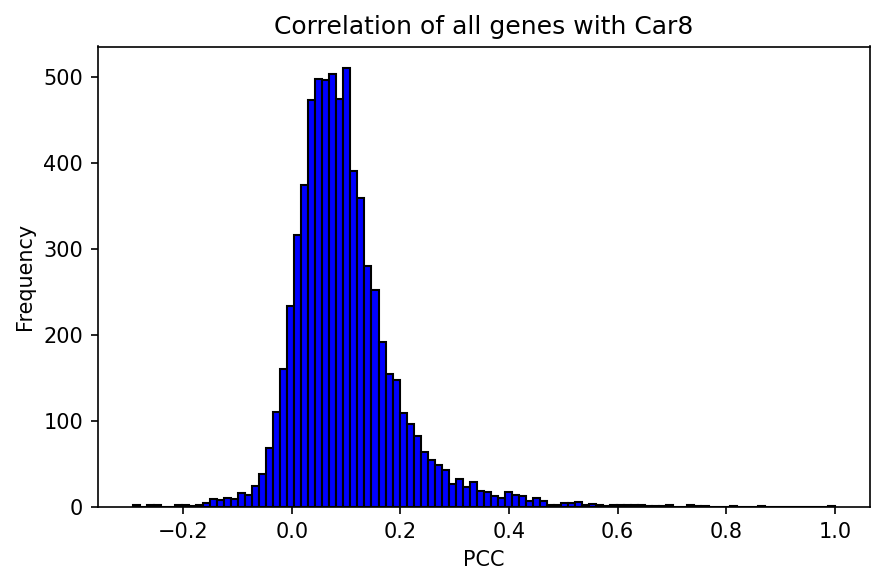

In [11]:
# Find top correlations or top anti-correlations to a gene of interest
#  (full documentation in Smoothie/src/spatial_correlation.py)

GOI_correlations = get_correlations_to_GOI(pearsonR_mat, 
                                           gene_names=sm_adata.var_names, 
                                           GOI="Car8", # choose gene
                                           reverse_order=False)

In [12]:
# Take a look at the top correlated genes 
GOI_correlations[0:21] # each row [gene, Pearson R Correlation Coefficient with GOI]

array([['Car8', 0.9999899864196777],
       ['Calb1', 0.8585575222969055],
       ['Pcp4', 0.8180155754089355],
       ['Ppp1r17', 0.7630385160446167],
       ['Pvalb', 0.7532631754875183],
       ['Nsg1', 0.7390881180763245],
       ['Ywhah', 0.7345186471939087],
       ['Rgs8', 0.7008211016654968],
       ['Pcp2', 0.6911134719848633],
       ['Gng13', 0.6796711683273315],
       ['Dner', 0.6755833029747009],
       ['Rora', 0.6608642339706421],
       ['Atp2a2', 0.649179220199585],
       ['Slc1a3', 0.6402336359024048],
       ['Homer3', 0.6376245617866516],
       ['Itpr1', 0.6269352436065674],
       ['Fam21', 0.6230431199073792],
       ['Kitl', 0.6191515922546387],
       ['Id2', 0.6102282404899597],
       ['Prkcg', 0.6030482649803162],
       ['Hpcal1', 0.6004548072814941]], dtype=object)

## Make Network for a Subset of Genes

In [ ]:
# Construct a network for a gene set of interest (a targeted approach), 
# using a more permissive pcc cutoff for higher geneset member retention.
#  (full documentation in Smoothie/src/network_analysis.py)

myGeneList = ['gene1', 'gene2', 'gene3']

geneset_edge_list, geneset_node_label_df = make_geneset_spatial_network(
    pearsonR_mat,
    gene_names=sm_adata.var_names,
    node_label_df=node_label_df,
    gene_list=myGeneList, # define how you'd like
    low_pcc_cutoff=0.2, # choose low_pcc_cutoff <= pcc_cutoff (from above)
    output_folder='/location/of/save/folder',
    intra_geneset_edges_only=True, # exclude edges between geneset and non-geneset members?
)

## Visualize Spatial Gene Plots

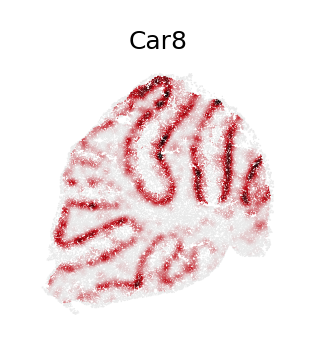

In [13]:
# Plot a gene of interest 
#  (full documentation in Smoothie/src/plotting.py)

plot_gene(sm_adata,
          gene_name='Car8', # choose gene
          output_folder='./Slideseq_demo_output', 
          save_plot=True,
          spot_size=25) # adjust spot_size to find optimal plotting resolution

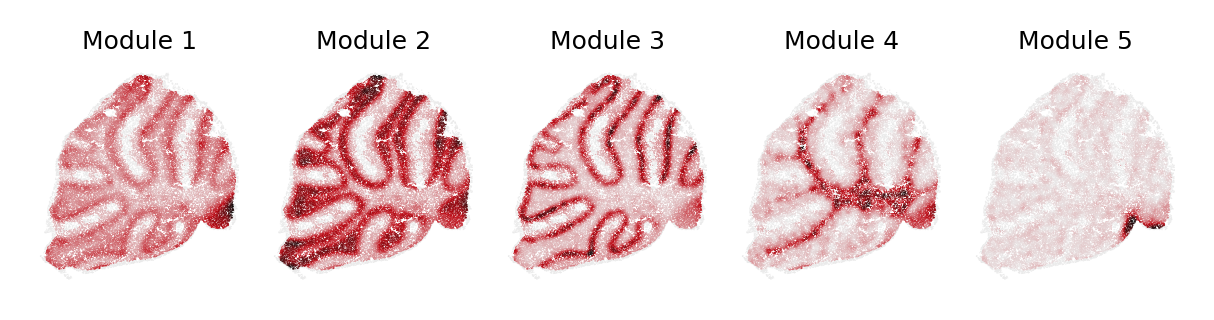

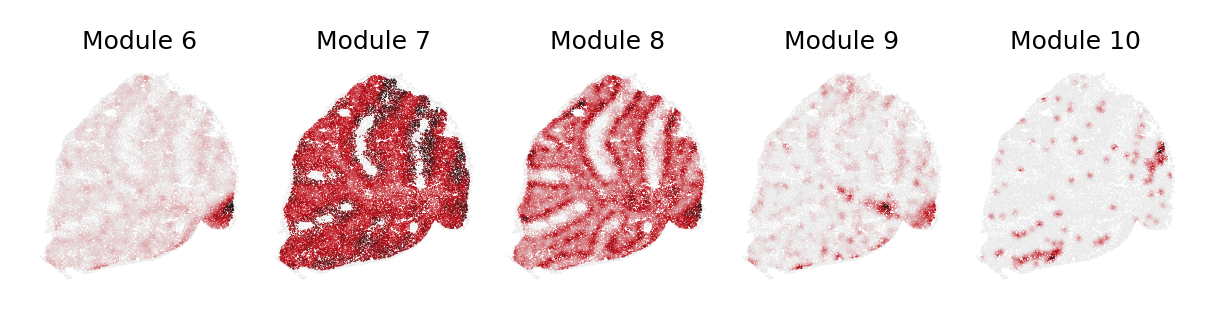

In [14]:
# Plot all gene modules 
#  (full documentation in Smoothie/src/plotting.py)

plot_modules(sm_adata, 
             node_label_df,
             output_folder='./Slideseq_demo_output',  
             plots_per_row=5, # number of module plots per plotting iteration
             min_genes=2, # minimum number of genes in a module to plot the module (Use 2 or 3).
             save_plot=True,
             spot_size=25) # adjust spot_size to find optimal plotting resolution